Target C6H6(GT)

* EDA: exploration of variables and properties of data with conclusions -  1
* Data preparation:  all  missing values  are filled/dropped with explanation of why some methodwas chosen -  1
* Data preparation: normalization of data / scaling -  1
* Baseline model - linear regression without regularization - 1
* Feature engineering -  basic transformations (nonlinear) -  2
* Metrics chosen as well as reasoning behind each metric - 1
* Feature importance, hyperparameters tuning -  1
* Statistics material used (residual analysis, factor-importance hypothesis testing) - 1
* Non-classic regression (SVM-regression, Kernel-regression, SGD-regression)-  1

In [487]:
import warnings
warnings.filterwarnings('ignore')

In [610]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, SGDRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

В файле были пустые строки в конце и абсолютно пустые последние столбцы, удалил всё это вручную

In [568]:
df = pd.read_csv('./AirQualityUCI.csv', sep=';', decimal=",")
df.head()

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6         1360       150      11.9   
1  10/03/2004  19.00.00     2.0         1292       112       9.4   
2  10/03/2004  20.00.00     2.2         1402        88       9.0   
3  10/03/2004  21.00.00     2.2         1376        80       9.2   
4  10/03/2004  22.00.00     1.6         1272        51       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0           1046      166          1056      113          1692         1268   
1            955      103          1174       92          1559          972   
2            939      131          1140      114          1555         1074   
3            948      172          1092      122          1584         1203   
4            836      131          1205      116          1490         1110   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

Добавим нормальную колонку со временем чтобы потом возможно вытянуть из нее какую-то информацию, удалим исходные

In [569]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', exact=True)
df = df.drop(columns=['Date', 'Time'])

В описании датасета сказано что пропуски закодированы числом -200

In [570]:
(df == -200).sum()/len(df)

CO(GT)           0.179865
PT08.S1(CO)      0.039115
NMHC(GT)         0.902319
C6H6(GT)         0.039115
PT08.S2(NMHC)    0.039115
NOx(GT)          0.175163
PT08.S3(NOx)     0.039115
NO2(GT)          0.175484
PT08.S4(NO2)     0.039115
PT08.S5(O3)      0.039115
T                0.039115
RH               0.039115
AH               0.039115
DateTime         0.000000
dtype: float64

Столбец NMHC(GT) довольно бесполезен, поскольку состоит на 90% из пропусков. Выпилим его сразу

In [571]:
df = df.drop(columns=['NMHC(GT)'])

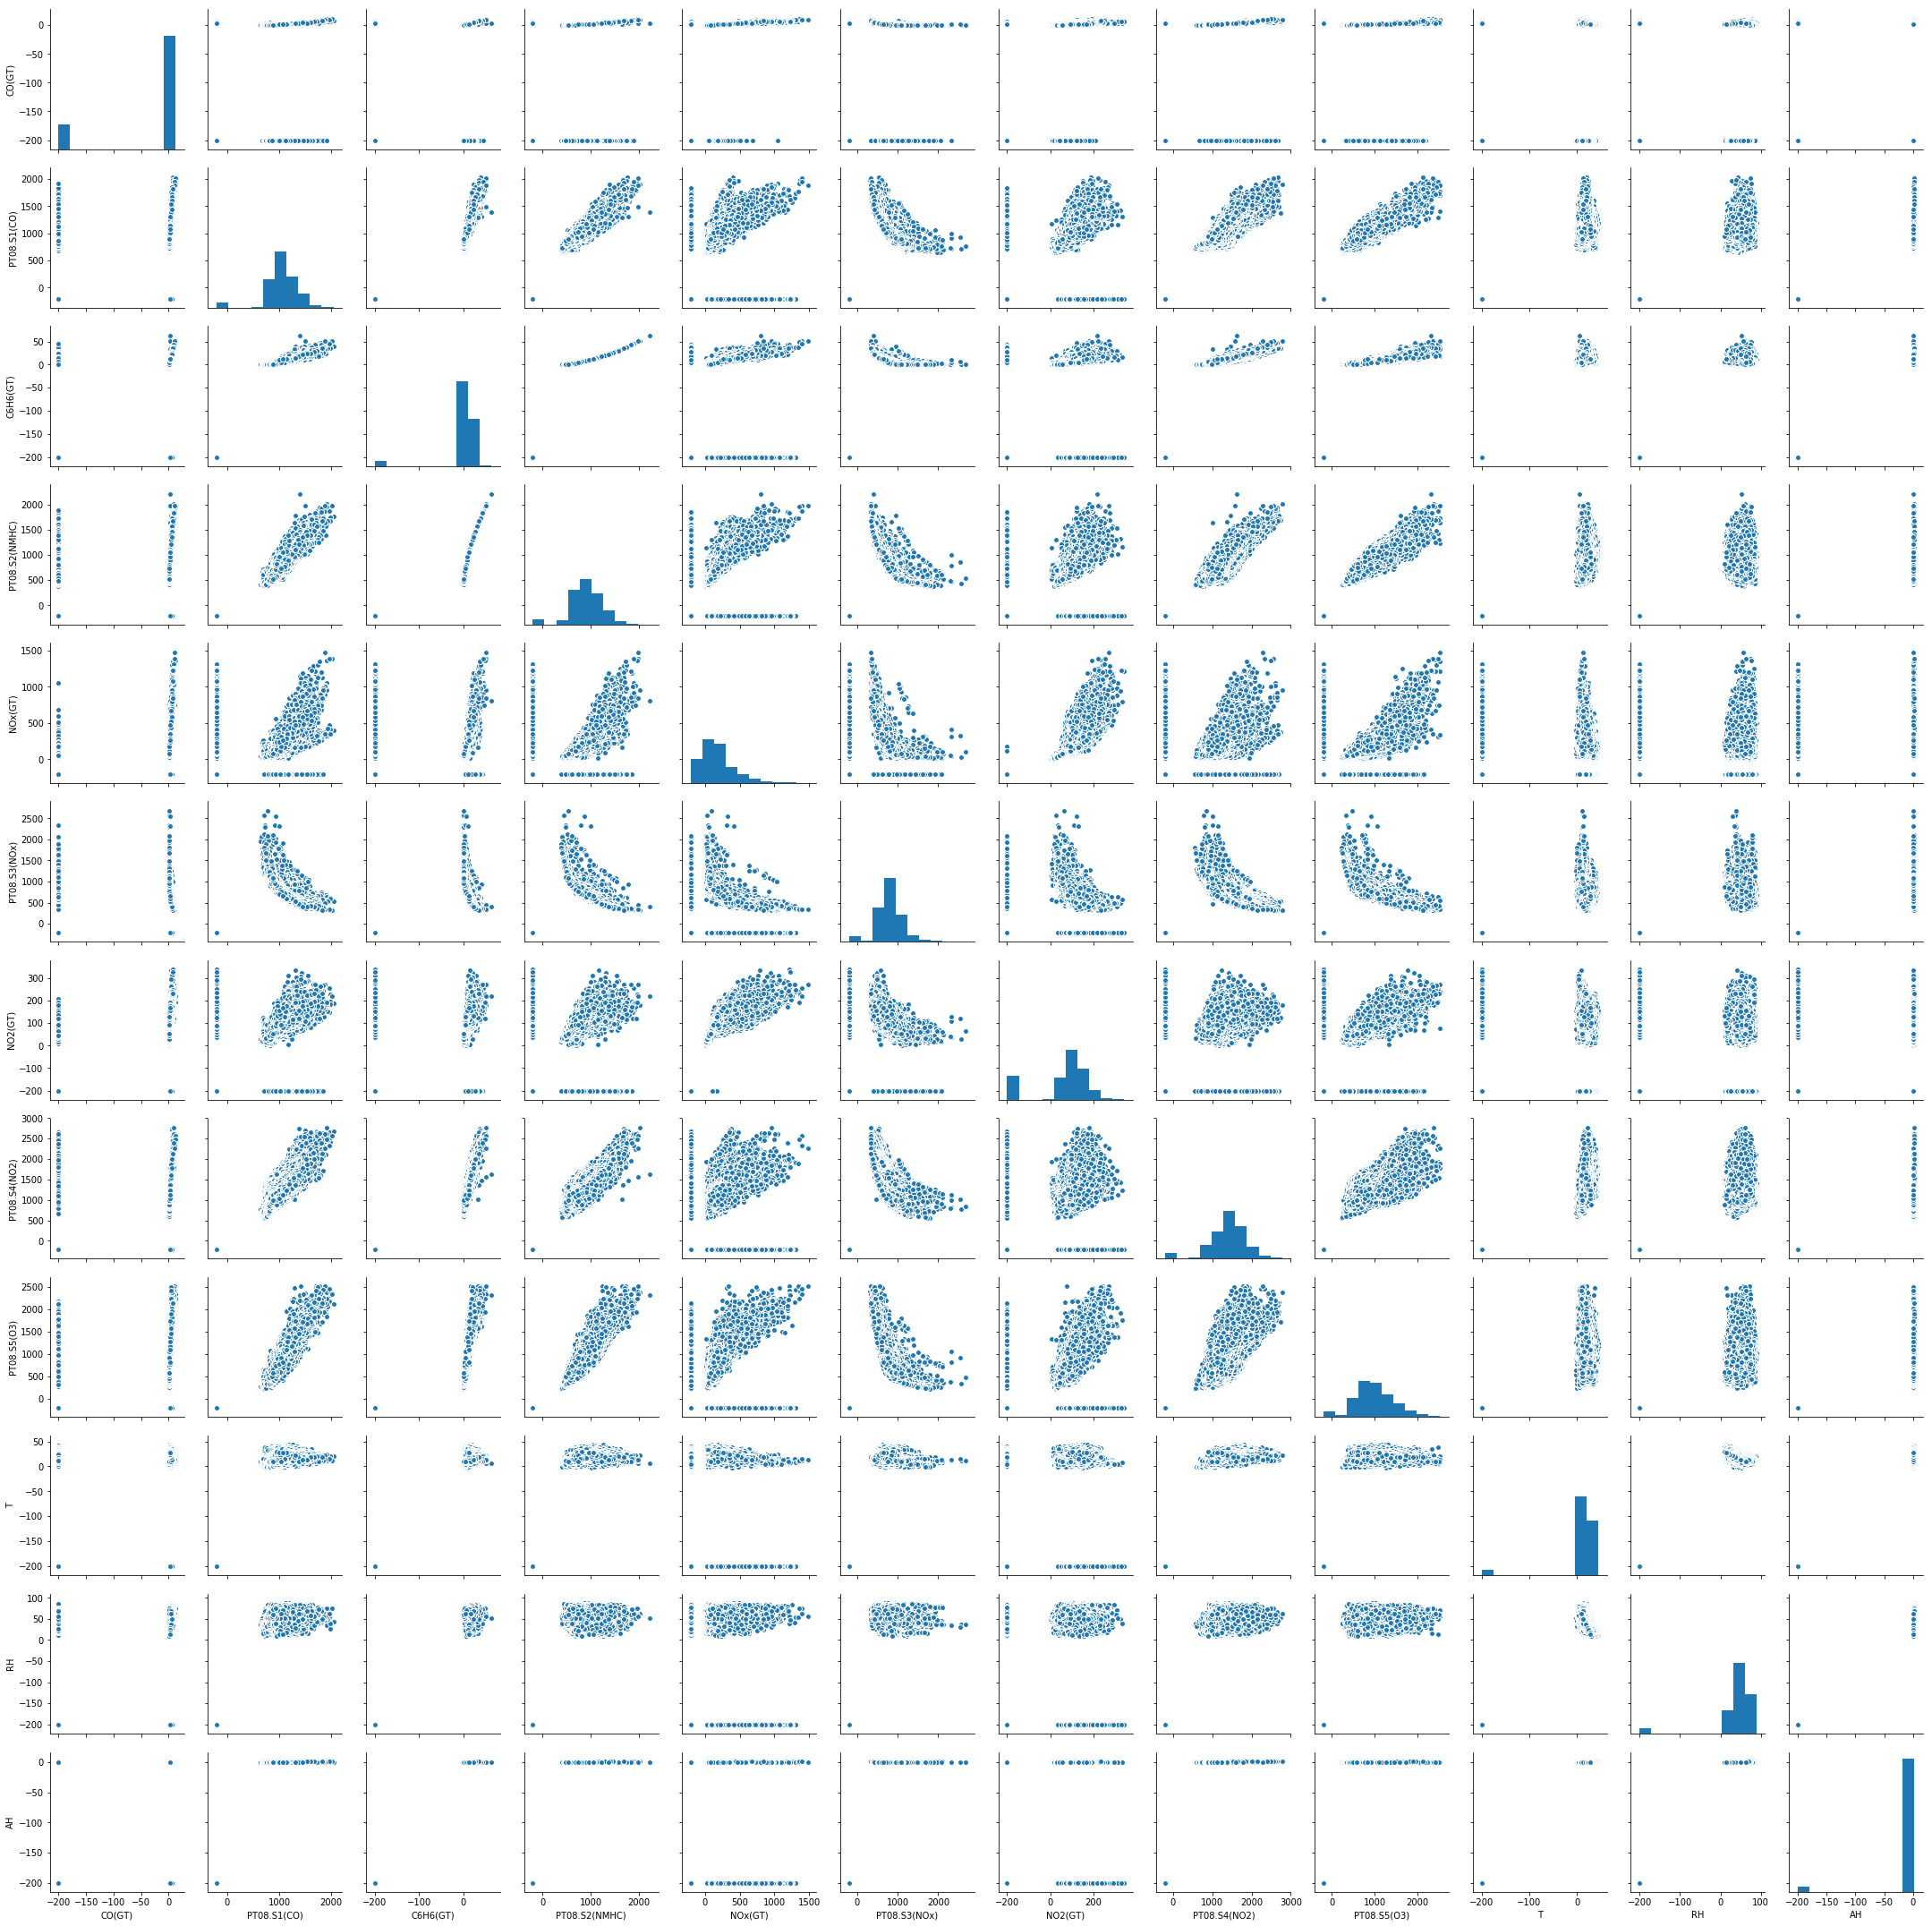

In [285]:
sns.pairplot(df)

Пока что не будем делать ниаких заключений о зависимостях между фичами, а удалим наблюдения с пропусками и выбросы, которые станут после этого видны

In [572]:
df1 = df.replace({-200: np.nan}).dropna(how='any')

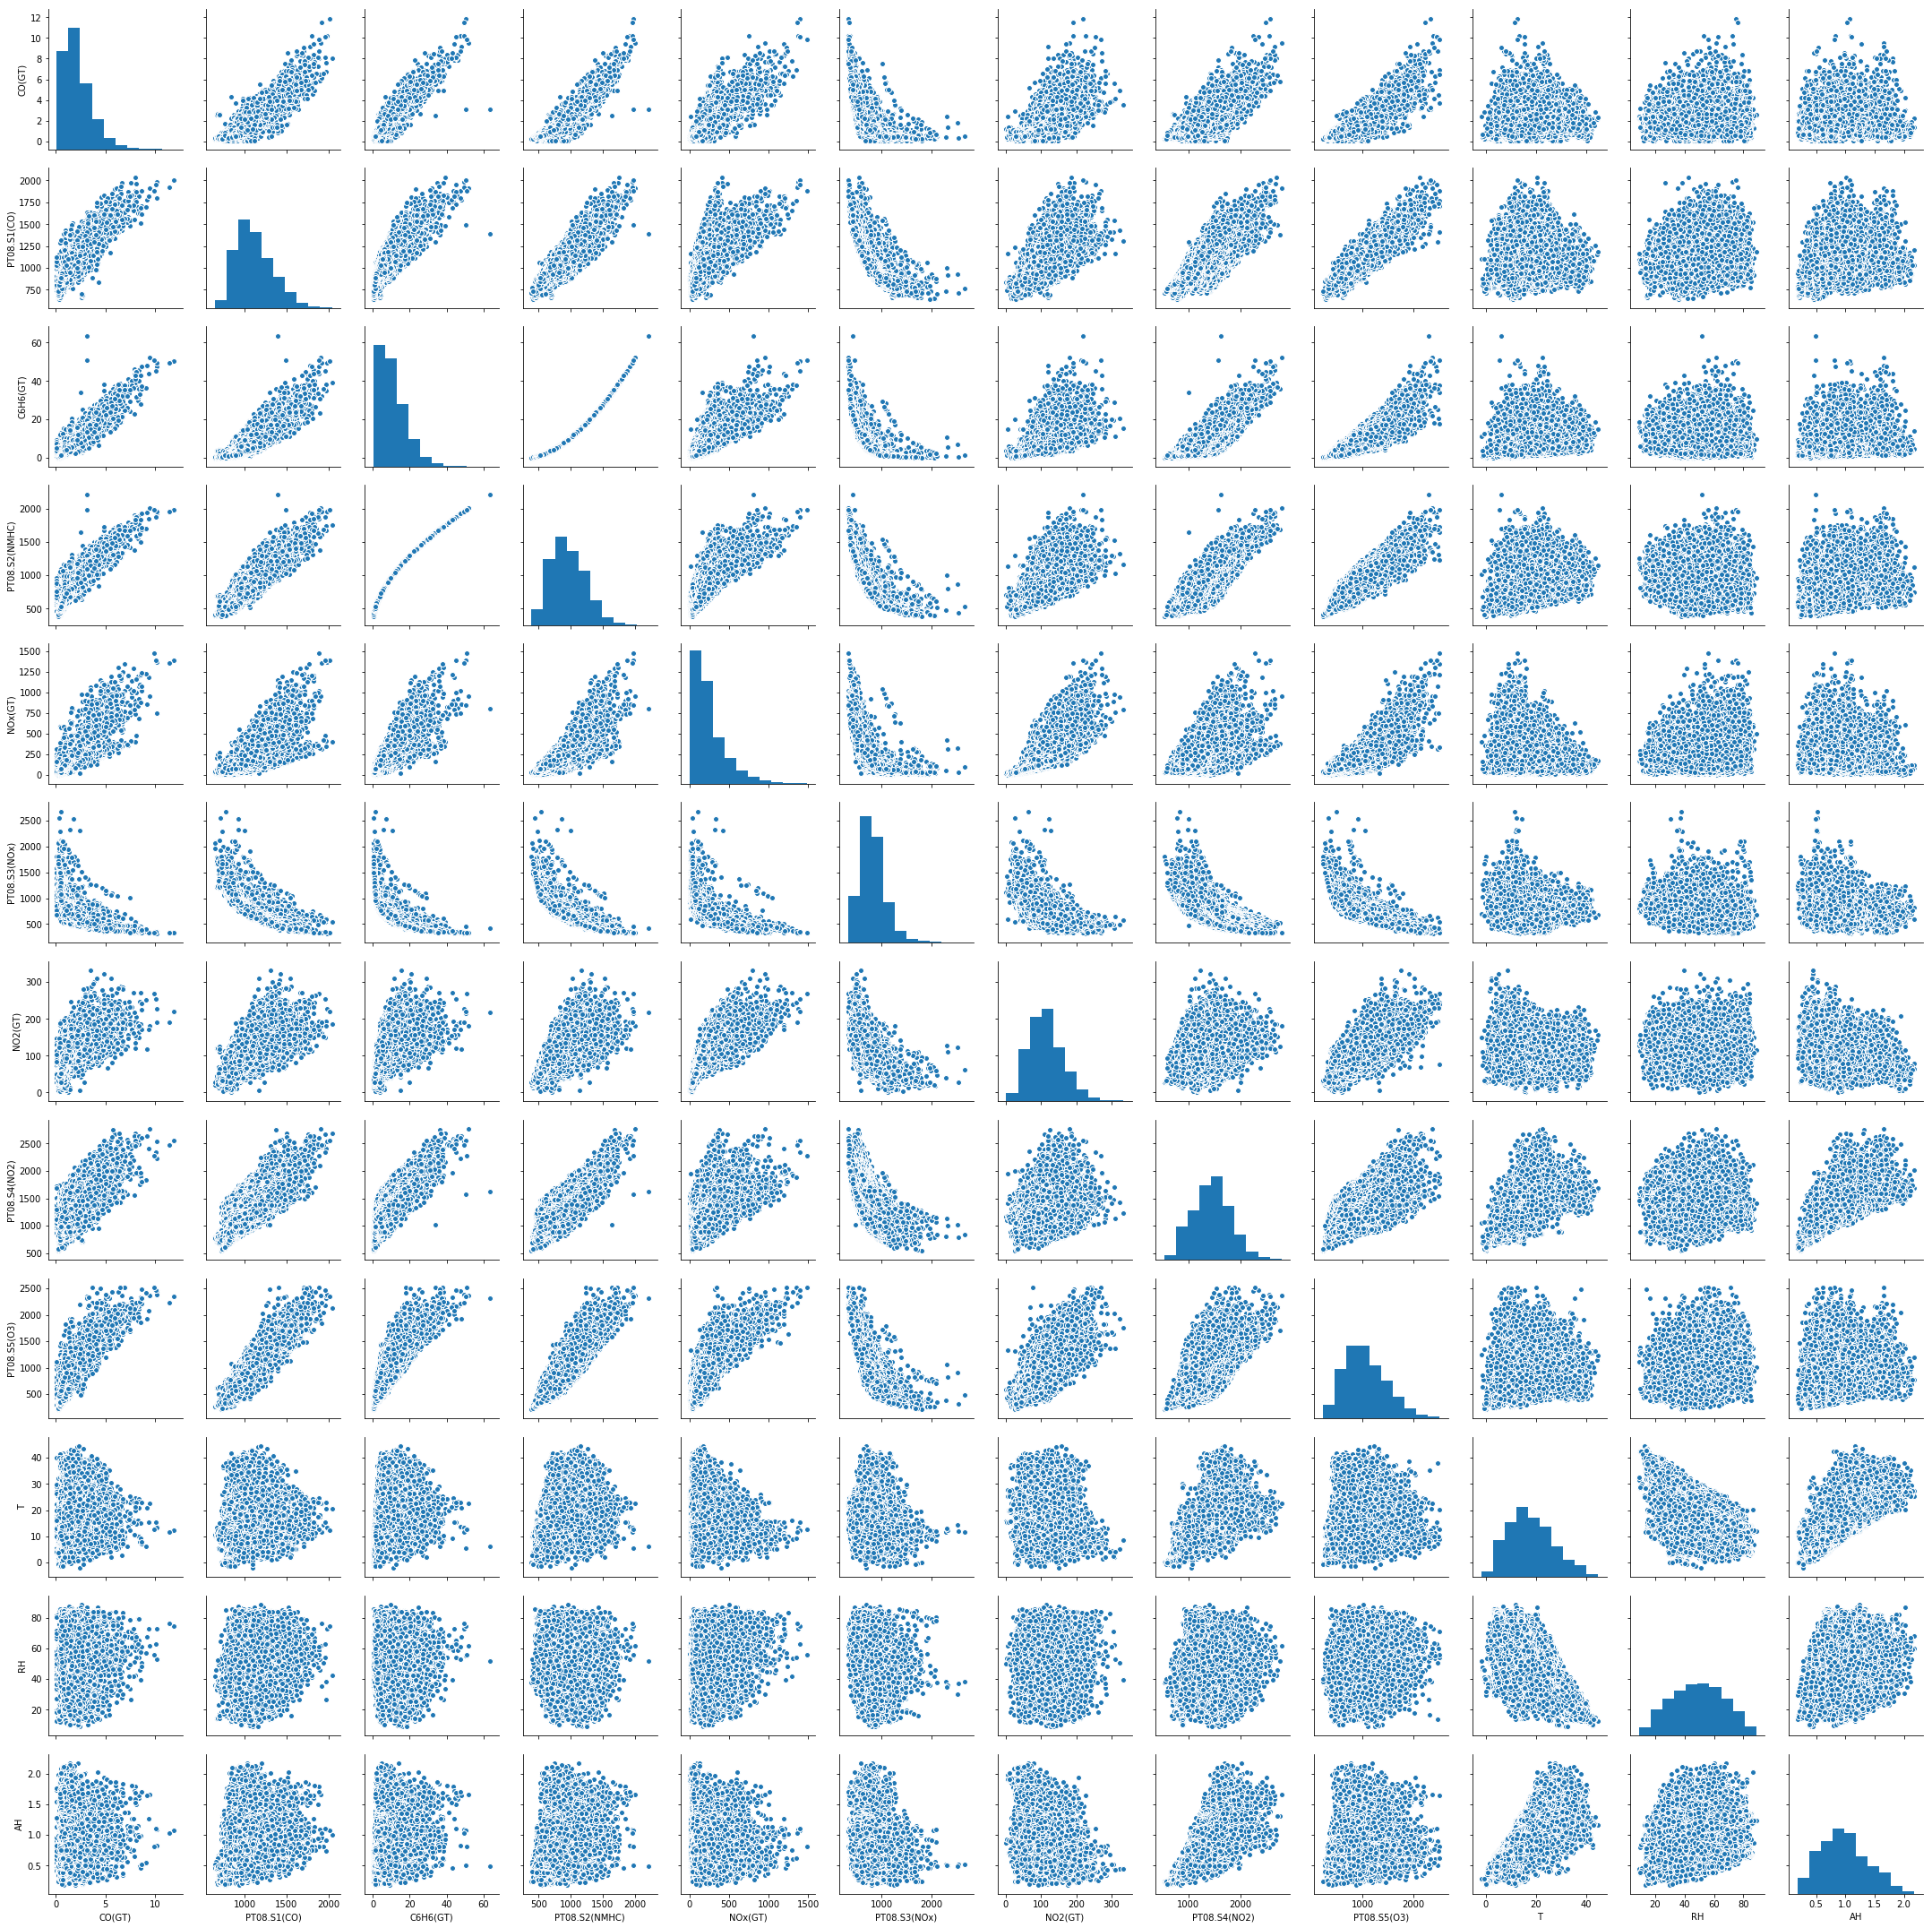

In [9]:
sns.pairplot(df1)

In [494]:
df1 = df1.drop(df1[df1['C6H6(GT)'] > 50].index)
df1 = df1.drop(df1[df1['CO(GT)'] > 11].index)
df1 = df1.drop(df1[df1['PT08.S3(NOx)'] > 2200].index)
df1 = df1.drop(df1[(df1['CO(GT)'] < 4) & (df1['C6H6(GT)'] > 30)].index)
df1 = df1.drop(df1[(df1['PT08.S1(CO)'] < 1600) & (df1['C6H6(GT)'] > 45)].index)
df1 = df1.drop(df1[(df1['PT08.S4(NO2)'] < 1700) & (df1['C6H6(GT)'] > 32)].index)
df1 = df1.drop(df1[(df1['NOx(GT)'] > 1300) & (df1['C6H6(GT)'] > 40)].index)

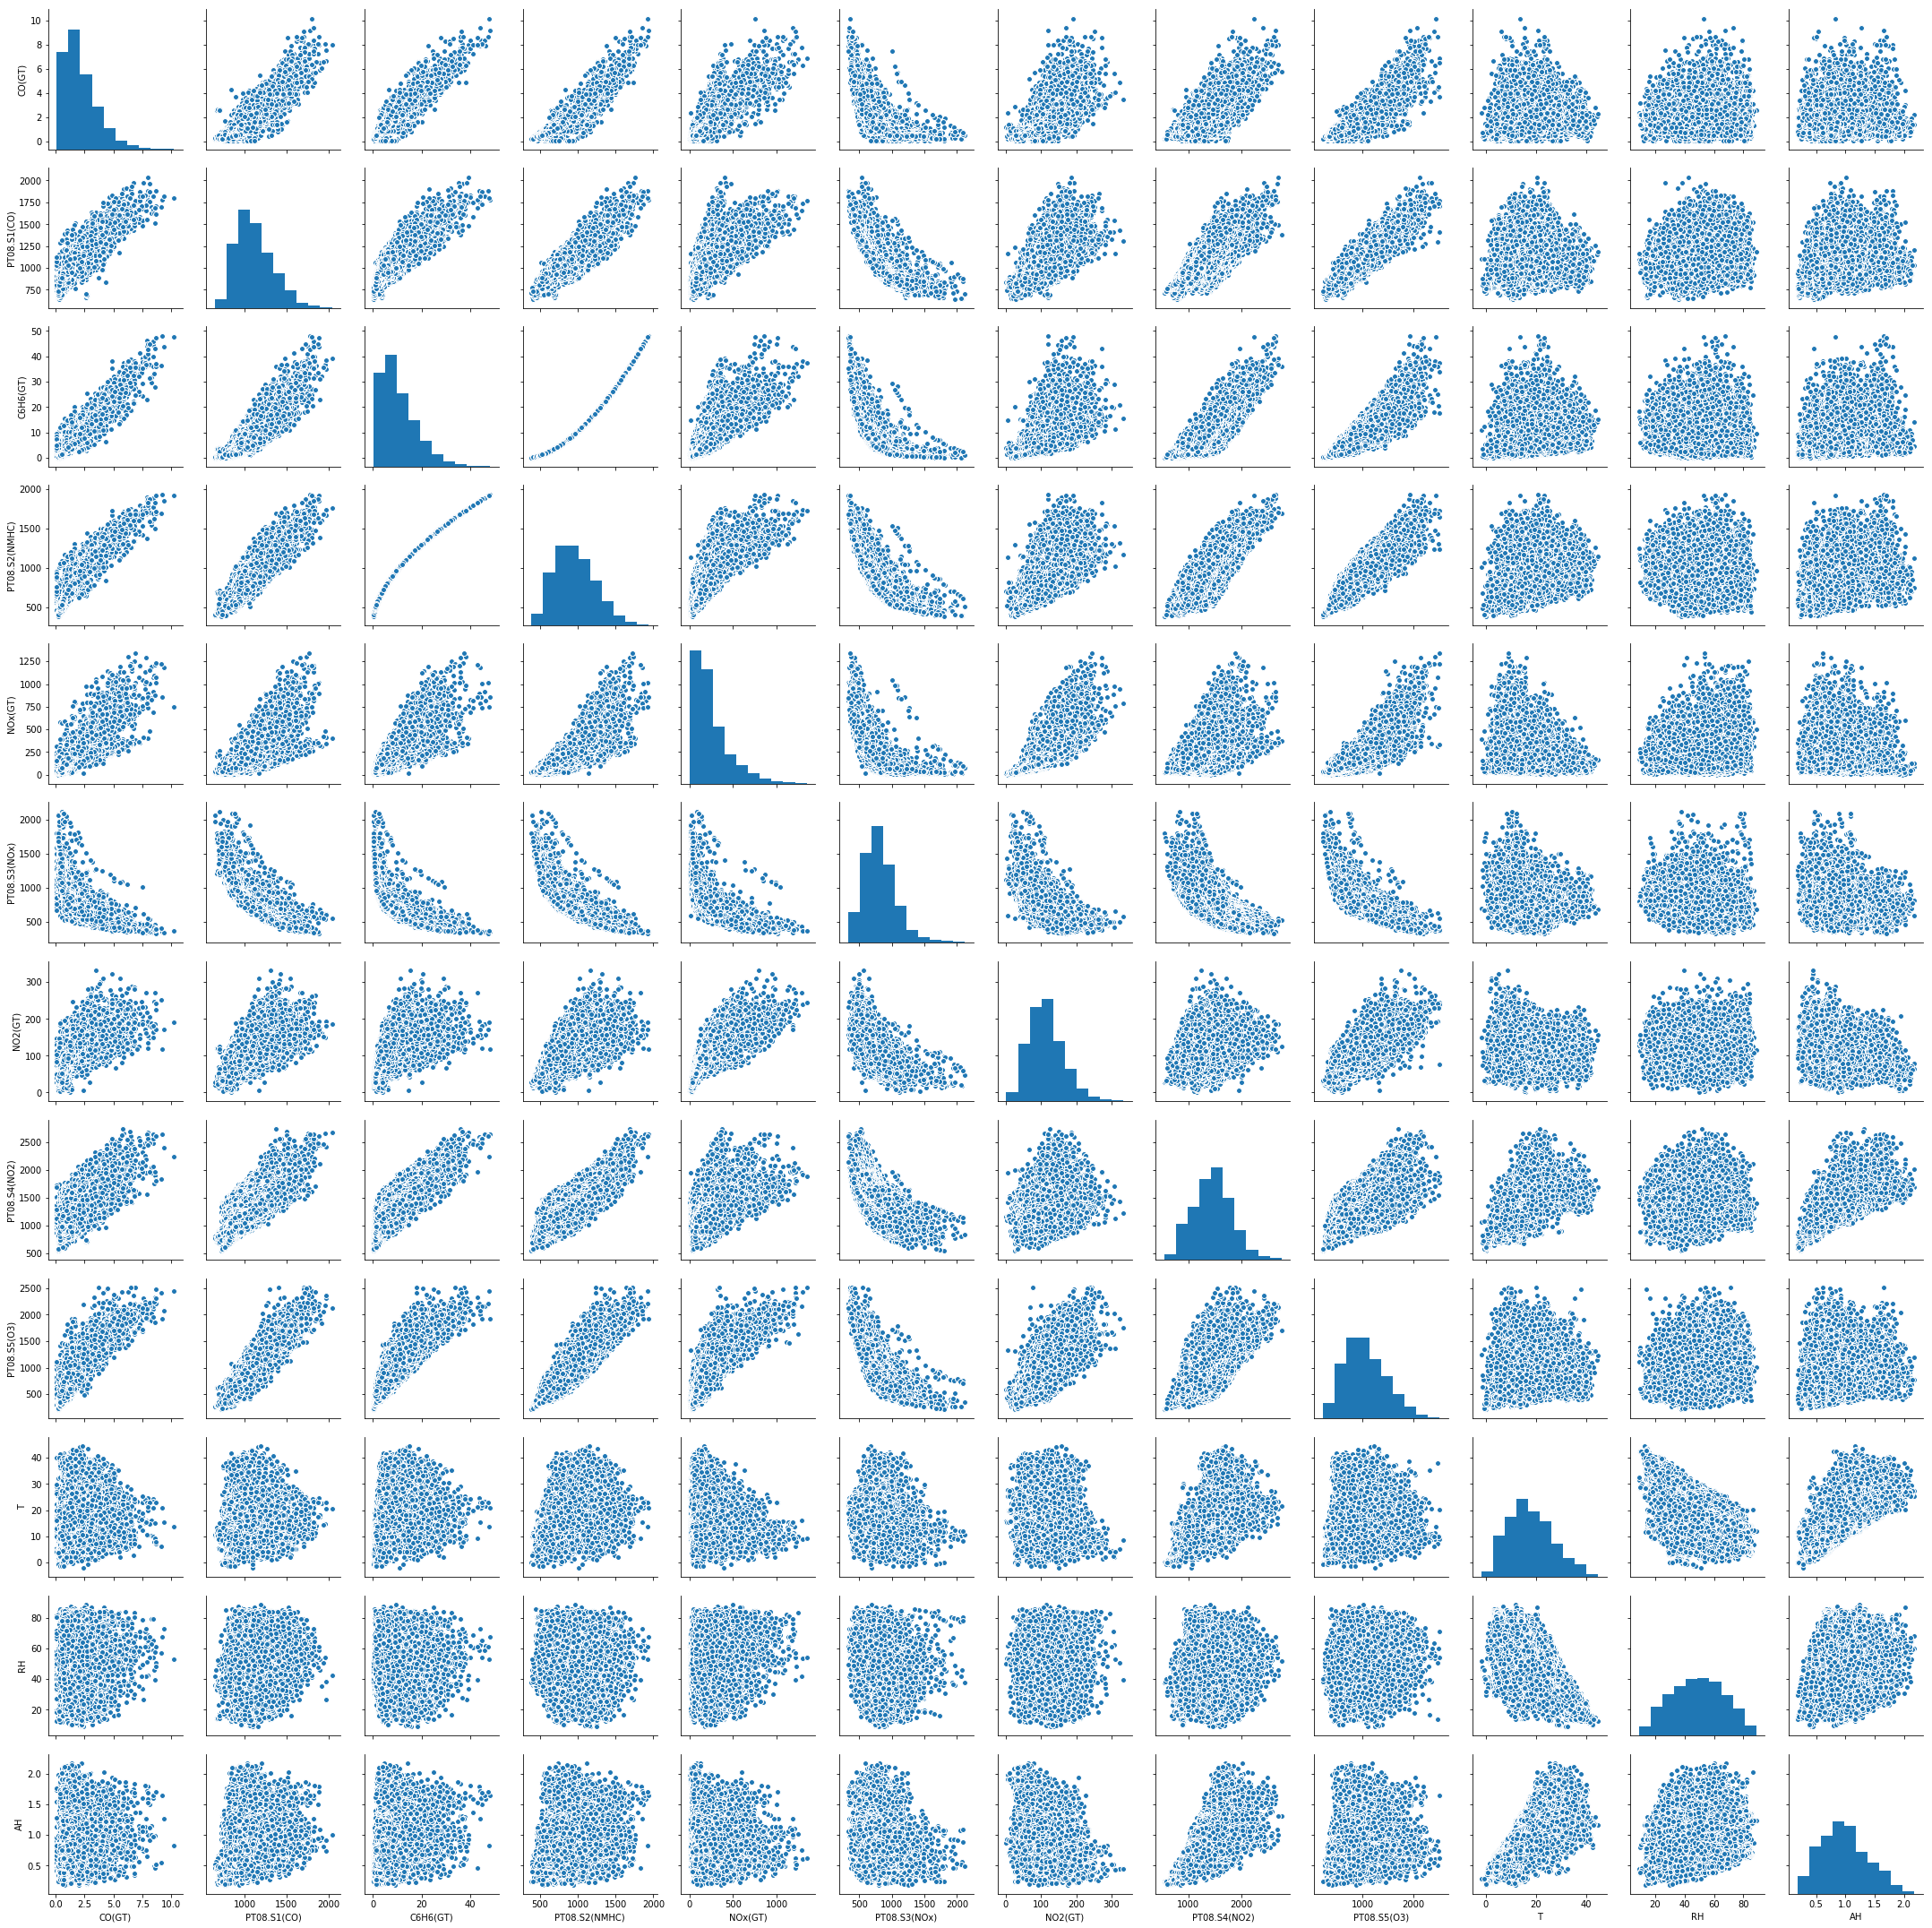

In [11]:
sns.pairplot(df1)

In [495]:
df1.corr()['C6H6(GT)']

CO(GT)           0.933357
PT08.S1(CO)      0.879284
C6H6(GT)         1.000000
PT08.S2(NMHC)    0.983823
NOx(GT)          0.712644
PT08.S3(NOx)    -0.737792
NO2(GT)          0.601595
PT08.S4(NO2)     0.765211
PT08.S5(O3)      0.861204
T                0.196689
RH              -0.027541
AH               0.191146
Name: C6H6(GT), dtype: float64

Последние три фичи что по графику, что по цифрам относительно бесполезны, не будем их использовать при построении моделей. С остальными довольно неплохая корреляция, что оправдывает применение регресионных моделей. Судя по графику признаки NOx(GT) и NO2(GT) довольно мусорные

Мы просто выбросили вообще все наблюдения с пропусками чтобы посмотреть на данные, однако нужно делать это очень аккуратно, у построенной модели может оказаться недостаточная обобщающая способность. Будем действовать следующим образом. Будем делать кросс-валидацию с помощью TimeSeriesSplit (у нас здесь временные ряды, заглядывать в будущее нехорошо), из трейна будем выкидывать все наблюдения с пропусками, обучать на этом модель, из теста выкидывать лишь наблюдения с пропусками в таргете, а остальные пропуски заменять средними значениями из соответствующих признаков трейна. Сразу заранее не выкидываем все наблюдения с пропусками в таргете потому, что в разных фичах их разное количество, и при отобре есть шанс получить больше информации, чем если бы мы выкинули всё сразу. Не будем забывать про масшабирование фич. В качестве метрики будем использовать MAE, потому что MSE будет давать нам заниженный результат при разнице значений меньше 1, а диапазон значений у таргета у нас довольно маленький. Всю эту хрень будет делать функция f. Сначала построим бейзлайн, затем произведем жадный отбор фич, затем наверное еще поразвлекаемся

In [573]:
def f(X, y, model, cv, metric):
    score = []
    coeff = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        index = X_train[X_train.isnull().any(axis=1)].index
        index = index.union(y_train[y_train.isnull()].index)
        X_train = X_train.drop(index)
        y_train = y_train.drop(index)
        
        index = y_test[y_test.isnull()].index
        X_test = X_test.drop(index)
        y_test = y_test.drop(index)
        X_test = X_test.fillna(X_train.mean())
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)
        score.append(metric(model.predict(X_test), y_test))
        coeff.append(model.coef_)
    
    return score, coeff

Заменим -200 на специально для этого предназначенный np.nan

In [574]:
df = df.replace({-200: np.nan})

Типа бейзлайн — попроубуем все фичи (кроме удаленной NMHC(GT) и DateTime)

In [575]:
y = df['C6H6(GT)']
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=7)

In [576]:
X = df[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
score, coeff = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

1.116636347273565

Будем выкидывать постпенно то, что хреново выглядит на графиках. Выкинем последние три, как планировали

In [536]:
X = df[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
score, _ = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

1.0582080504174294

Чудесно. Выкинем NO2(GT)

In [537]:
X = df[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
score, _ = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

1.0724212101255135

Эээм, не будем выкидывать NO2(GT), вместо нее выкинем NOx(GT)

In [538]:
X = df[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',  'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
score, _ = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

1.055882364419698

Странно. А если еще раз выкинуть NO2(GT)?

In [503]:
X = df[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
score, coeff = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

1.002995555977312

In [504]:
score[-1], coeff[-1]

(1.0106090257073408,
 array([ 1.49392798, -0.30987971,  6.58229448,  0.87742505,  0.25786625,
         0.31520452]))

Выкинем PT08.S1(CO)

In [505]:
X = df[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']]
score, coeff = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

0.9481811755931159

In [506]:
score[-1], coeff[-1]

(0.9515363786977389,
 array([1.38591364, 6.59735964, 0.88623613, 0.19612306, 0.15860949]))

Попробуем выкинуть 'PT08.S4(NO2)', 'PT08.S5(O3)'

In [507]:
X = df[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)']]
score, coeff = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

0.9195149550613326

In [508]:
score[-1], coeff[-1]

(0.93445860540383, array([1.35402288, 6.91287191, 0.88102136]))

Ну вот мы и нашли самые важные признаки. Еще раз взглянем, что это за признаки

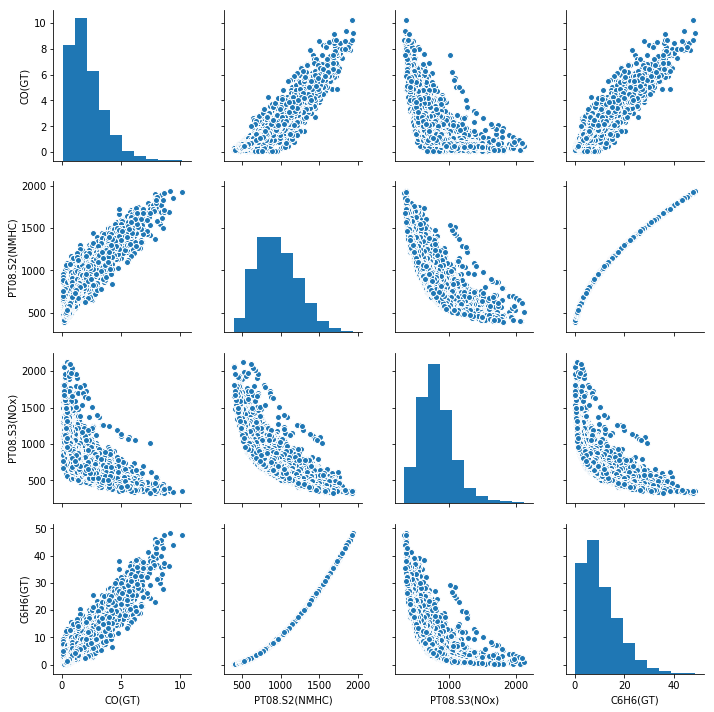

In [301]:
df2 = df1[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'C6H6(GT)']]
sns.pairplot(df2)

Попробуем выпрямить кривые между таргетом и PT08.S2(NMHC), таргетом и PT08.S3(NOx)

/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/majestic905/.venvs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


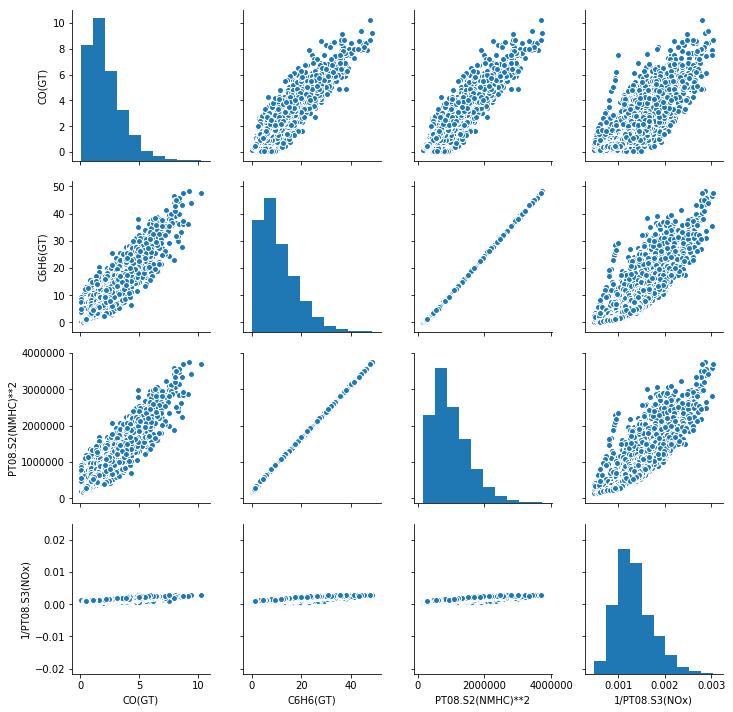

In [302]:
df2['PT08.S2(NMHC)**2'] = df2['PT08.S2(NMHC)']**2
df2['1/PT08.S3(NOx)'] = 1/df2['PT08.S3(NOx)']
df2 = df2.drop(columns=['PT08.S3(NOx)', 'PT08.S2(NMHC)'])
sns.pairplot(df2)

Добавим их в последнюю модель

In [596]:
X = df[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)']]
X['PT08.S2(NMHC)**2'] = X['PT08.S2(NMHC)']**2
X['1/PT08.S3(NOx)'] = 1/X['PT08.S3(NOx)']
score, coeff = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

0.05046574927671823

In [540]:
score[-1], coeff[-1]

(0.05486839616022417,
 array([ 0.01245202, -0.57100013,  0.07478338,  8.13160929,  0.05639613]))

С одной стороны хорошо, что такую ошибку маленькую получили в итоге, с другой видно, что модель тащит по большому счету одна фича, помимо того что их всего по факту 3 штуки, что хреново, поскольку если в тесте будет пропущенное значение в этом признаке или в двух, или во всех трех, то тогда модель скорее всего соснет. С третьей стороны, соснуть она должна не то чтобы прям космически, ибо пропуск мы заменяем на среднее по прошлым наблюдениям

In [541]:
df['PT08.S2(NMHC)'].isnull().sum()/len(df)

0.0391151009939083

С четвертой стороны, во всем датасете лишь 4 процента пропущенных значений у этого признака, есть основания предполагать, что модель будет хреново себя вести лишь примерно в 4 процентах случаев, что в общем то весьма неплохо

Но все-таки посмотрим, что будет, если в PT08.S2(NMHC) будет пропуск — заменим в тесте этот признак на среднее по трейну

In [542]:
def g(X, y, model, cv, metric):
    score = []
    coeff = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        index = X_train[X_train.isnull().any(axis=1)].index
        index = index.union(y_train[y_train.isnull()].index)
        X_train = X_train.drop(index)
        y_train = y_train.drop(index)
        
        index = y_test[y_test.isnull()].index
        X_test = X_test.drop(index)
        y_test = y_test.drop(index)
        X_test['PT08.S2(NMHC)'] = np.nan
        X_test = X_test.fillna(X_train.mean())
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)
        score.append(metric(model.predict(X_test), y_test))
        coeff.append(model.coef_)
    
    return score, coeff

In [543]:
X = df[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)']]
X['1/PT08.S3(NOx)'] = 1/X['PT08.S3(NOx)']
score, coeff = g(X, y, model, tscv, mean_absolute_error)
np.mean(score)

5.133245642929124

Не, соснули мы все-таки космически. Одним из выходов в этой ситуации видится постановка отдельной задачи предсказания 
PT08.S2(NMHC) по остальным признакам

Вернем нормальную функцию f

In [545]:
y = df['PT08.S2(NMHC)']
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=7)

In [546]:
X = df[['CO(GT)', 'NOx(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH']]
X['1/PT08.S3(NOx)'] = 1/df['PT08.S3(NOx)']
# X['dow'] = df['DateTime'].apply(lambda x: x.date().weekday()+1)
# X['hour'] = df['DateTime'].apply(lambda x: x.time().hour+1)
# X['morning'] = df['DateTime'].apply(lambda x: 1 if 6 <= x.time().hour < 12 else 0)
# X['day'] = df['DateTime'].apply(lambda x: 1 if 12 <= x.time().hour < 22 else 0)
# X['evening'] = df['DateTime'].apply(lambda x: 1 if 22 <= x.time().hour or x.time().hour < 6 else 0)
score, coeff = f(X, y, model, tscv, mean_absolute_error)
np.mean(score)

47.6143513087474

Посмотрим, что будет, если в PT08.S2(NMHC) пропуски мы будем предсказывать, т.е. посмотрим, что будет, если вместо превращения PT08.S2(NMHC) в тесте в np.nan будем его предсказывать

In [577]:
def g(X, y, Xt, model):
    index = X[X.isnull().any(axis=1)].index
    index = index.union(y[y.isnull()].index)
    X = X.drop(index)
    y = y.drop(index)

    Xt = Xt.fillna(X.mean())

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Xt = scaler.transform(Xt)

    model.fit(X, y)
    return model.predict(Xt)

In [598]:
def h(X, y, model, cv, metric):
    score = []
    coeff = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_test['PT08.S2(NMHC)'] = g(X_train[['CO(GT)', 'NOx(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH', '1/PT08.S3(NOx)']],
                                    X_train['PT08.S2(NMHC)'],
                                    X_test[['CO(GT)', 'NOx(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH', '1/PT08.S3(NOx)']],
                                    model)
        
        X_train = X_train[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', '1/PT08.S3(NOx)']]
        X_test = X_test[['CO(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', '1/PT08.S3(NOx)']]
        X_train['PT08.S2(NMHC)**2'] = X_train['PT08.S2(NMHC)']**2
        X_test['PT08.S2(NMHC)**2'] = X_test['PT08.S2(NMHC)']**2
        index = X_train[X_train.isnull().any(axis=1)].index
        index = index.union(y_train[y_train.isnull()].index)
        X_train = X_train.drop(index)
        y_train = y_train.drop(index)
        
        index = y_test[y_test.isnull()].index
        X_test = X_test.drop(index)
        y_test = y_test.drop(index)
        X_test = X_test.fillna(X_train.mean())
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(X_train, y_train)
        score.append(metric(model.predict(X_test), y_test))
        coeff.append(model.coef_)
    
    return score, coeff

In [599]:
X = df[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
X['1/PT08.S3(NOx)'] = 1/X['PT08.S3(NOx)']
score, coeff = h(X.copy(), y.copy(), model, tscv, mean_absolute_error)
np.mean(score)

1.3179550284088257

Это значительно меньше 5.133245642929124. Есть основания полагать, что таким образом можно улучшить модель в тех примерно 4 процентах случаев, когда она должна вести себя хреново. Но проверить это на датасете нельзя, потому что пропуски PT08.S2(NMHC) идут лишь одновременно с таргетом, а пропуски последнего на тесте вы выкидываем.

Вот таким образом построили относительно хорошую модель, и главный вывод, который можно сделать — ключ к успешному решению задачи в генерации хороших фич

Попробуем натравить на очищенный ранее от пропусков и выбросов датасет SGDRegressor

In [656]:
X = df1[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
# X['PT08.S2(NMHC)**2'] = X['PT08.S2(NMHC)']**2
# X['1/PT08.S3(NOx)'] = 1/X['PT08.S3(NOx)']
y = df1['C6H6(GT)']

In [657]:
scaler = StandardScaler()
model = SGDRegressor()
pipeline = Pipeline([('scale', scaler), ('sgd', model)])
pipeline.fit(X, y)
params = {'sgd__penalty': ['l1', 'l2'], 'sgd__alpha': [0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 100], 'sgd__learning_rate': ['optimal', 'invscaling']}
tscv = TimeSeriesSplit(n_splits=5)
gs = GridSearchCV(pipeline, params, scoring='neg_mean_absolute_error', cv=tscv)

In [658]:
gs.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sgd__learning_rate': ['optimal', 'invscaling'], 'sgd__alpha': [0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 100], 'sgd__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [659]:
np.max(gs.cv_results_['mean_test_score'])

-0.9333480234791278

В принципе результат сравнимый с бейзлайном MAE 0.93. Попробуем добавить две придуманные фичи

In [660]:
X['PT08.S2(NMHC)**2'] = X['PT08.S2(NMHC)']**2
X['1/PT08.S3(NOx)'] = 1/X['PT08.S3(NOx)']

gs.fit(X, y)

np.max(gs.cv_results_['mean_test_score'])

-0.5043033490072616

Ожидаемо лучше, но хуже, чем получилось сделать руками, хотя возможно здесь играет роль специфика алгоритма